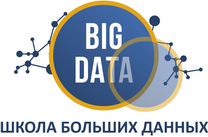

[перейти](https://www.bigdataschool.ru/)

In [41]:
%pip install pymorphy2 nltk
import pandas as pd
import numpy as np
import nltk
import re
import csv
from nltk.stem import WordNetLemmatizer
import sklearn
import codecs
import pymorphy2
import seaborn as sns
sns.set_style("darkgrid")
from nltk.stem.snowball import SnowballStemmer

Note: you may need to restart the kernel to use updated packages.


### Функции

In [42]:
def csv_to_list(arr):
    arr_list = []
    for row in arr:
        arr_list.append(list_to_str(row))
    return arr_list

def list_to_str(arr):
    str_ = ''
    for rec in arr:
        str_+=rec
    return str_

def df_preprocess(text:str):    
    reg = re.compile('[^а-яА-яa-zA-Z0-9 ]') #
    text = text.lower().replace("ё", "е")
    text = text.replace("ъ", "ь")
    text = text.replace("й", "и")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'сайт', text)
    text = re.sub('@[^\s]+', 'пользователь', text)
    text = reg.sub(' ', text)
    
    # Лемматизация
    # morph = pymorphy2.MorphAnalyzer()
    # text =[morph.parse(word)[0].normal_form for word in text.split()]

    # Стемминг
    stemmer = SnowballStemmer("russian")
    text =[stemmer.stem(word) for word in text.split()]

    return text

### Считываем данные

Используем корпус с сайта https://study.mokoron.com/#download

In [43]:
positive_recalls = csv_to_list(csv.reader(codecs.open('./positive_recalls.csv', 'rU', 'utf-8', errors='ignore')))
negative_recalls = csv_to_list(csv.reader(codecs.open('./negative_recalls.csv', 'rU', 'utf-8', errors='ignore')))

In [44]:
# Пример положительного твита
positive_recalls[10]

'Люблю маму и папу!!!!а в остальное я так...-влюбляюсь привязываюсь)))\xa0'

In [45]:
# Пример положительного твита
positive_recalls[100]

'@jolechka3 получаетсяосторожно котлетку перекладываю в др.посуду)'

In [46]:
# Пример негативного твита
negative_recalls[15]

'Скоро увижу твои зеленые глаза в последний раз((('

In [47]:
# Пример негативного твита
negative_recalls[150]

'RT @oksakov: Приехала домой мне вообще плохо( Устала.'

In [48]:
type(negative_recalls)

list

In [49]:
len(negative_recalls)

111923

In [50]:
len(positive_recalls)

114911

### Формируем датасет 

In [51]:
df_positive_recalls = pd.DataFrame(positive_recalls, columns=['recall'])
df_positive_recalls['type']=1
df_positive_recalls.head()

,recall,type
0,@first_timee хоть я и школота но поверь у нас ...,1
1,Да все-таки он немного похож на него. Но мой м...,1
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1


In [52]:
df_negative_recalls = pd.DataFrame(negative_recalls, columns=['recall'])
df_negative_recalls['type']=0
df_negative_recalls.head()

,recall,type
0,на работе был полный пиддес :| и так каждое за...,0
1,Коллеги сидят рубятся в Urban terror а я из-за...,0
2,@elina_4post как говорят обещаного три года жд...,0
3,Желаю хорошего полёта и удачной посадкия буду ...,0
4,Обновил за каким-то лешим surf теперь не работ...,0


In [53]:
# Объединяем два датафрейма вместе
df_recalls = pd.concat((df_negative_recalls, df_positive_recalls),axis = 0).sample(frac = 1.0) # объединяем и перемешиваем
df_recalls.head()

,recall,type
21467,Лучше голос сорвать..кричааааать) — нравится н...,1
21795,"наконец то я дома...\nно я не знаю, чем мне за...",0
113689,@Rinkanew @StJimmyFromMars но только не тебяты...,1
114075,Не боишься стать открытой книгой после всех от...,1
99427,RT @NastyaSinger: Ну похож же:)) @adlerlessfra...,1


### Очитска текста приведение слов к стандартному виду

In [54]:
print(df_recalls['recall'].iloc[0])
%time print(df_preprocess(df_recalls['recall'].iloc[0]))

Лучше голос сорвать..кричааааать) — нравится нравится песня))) http://t.co/ntvOIQCYnr
['лучш', 'голос', 'сорва', 'кричааааа', 'нрав', 'нрав', 'песн', 'сайт']
CPU times: total: 0 ns
Wall time: 0 ns


In [55]:
print(df_recalls['recall'].iloc[0])
%time print(df_preprocess(df_recalls['recall'].iloc[0]))

Лучше голос сорвать..кричааааать) — нравится нравится песня))) http://t.co/ntvOIQCYnr
['лучш', 'голос', 'сорва', 'кричааааа', 'нрав', 'нрав', 'песн', 'сайт']
CPU times: total: 0 ns
Wall time: 1.04 ms


In [56]:
%time df_recalls['recall'] = df_recalls['recall'].apply(df_preprocess)

CPU times: total: 1min 23s
Wall time: 1min 23s


In [57]:
df_recalls.head()

,recall,type
21467,"[лучш, голос, сорва, кричааааа, нрав, нрав, пе...",1
21795,"[наконец, то, я, дом, но, я, не, зна, чем, мне...",0
113689,"[пользовател, пользовател, но, тольк, не, тебя...",1
114075,"[не, бо, стат, открыто, книго, посл, всех, отв...",1
99427,"[rt, пользовател, ну, похож, же, пользовател, ...",1


### Выполнить обработку текстовых данных датасета "20 News groups"

In [58]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [59]:
dir(newsgroups_train)

['DESCR', 'data', 'filenames', 'target', 'target_names']

## Создание датасетов

Для начала нужно сбросить убрать из словаря поля, которые не имеют той же длины, что и основные значения датасета. Информация взята [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)

In [60]:
DESCR_train = newsgroups_train.pop('DESCR')
target_names_train = newsgroups_train.pop('target_names')

DESCR_test = newsgroups_test.pop('DESCR')
target_names_test = newsgroups_test.pop('target_names')

Теперь сделаем и данных датасеты

In [61]:
newsgroups_train_df = pd.DataFrame(newsgroups_train)
newsgroups_train_df.head()

,data,filenames,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,14


In [62]:
newsgroups_test_df = pd.DataFrame(newsgroups_test)
newsgroups_test_df.head()

,data,filenames,target
0,From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. ...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,7
1,From: Rick Miller <rick@ee.uwm.edu>\nSubject: ...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,5
2,From: mathew <mathew@mantis.co.uk>\nSubject: R...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,0
3,From: bakken@cs.arizona.edu (Dave Bakken)\nSub...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,17
4,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,C:\Users\VPR\scikit_learn_data\20news_home\20n...,19


Дальше удалим у обоих датасетов колонку с именем файла, так как оно не должно влиять на само сообщение

In [63]:
newsgroups_train_df = newsgroups_train_df.drop(columns=['filenames'], axis=0)
newsgroups_test_df = newsgroups_test_df.drop(columns=['filenames'], axis=0)

Теперь посмотрим на то, что содержится в колонке данных

In [64]:
newsgroups_train_df.data[:4]

0    From: lerxst@wam.umd.edu (where's my thing)\nS...
1    From: guykuo@carson.u.washington.edu (Guy Kuo)...
2    From: twillis@ec.ecn.purdue.edu (Thomas E Will...
3    From: jgreen@amber (Joe Green)\nSubject: Re: W...
Name: data, dtype: object

In [65]:
for i in range(5):
    print('-------------')
    print(newsgroups_train_df.data[i])
    print('-------------')



-------------
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





-------------
-------------
From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washingto

Это похоже на электронные письма, которые приходят в газетные редакции.

Для начала приведем все к нижнему регистру

In [66]:
newsgroups_train_df.data = newsgroups_train_df.data.apply(lambda text: text.lower())
newsgroups_test_df.data = newsgroups_test_df.data.apply(lambda text: text.lower())

Теперь нужно очистить текст от лишних фрагментов. В каждом письме повторяется несколько блоков:
- From - от кого письмо, скорее всего не должно влиять на тему, потому что организации могут менять адреса или это может быть физическое лицо
- Subject - тема письма. Может оказывать влияние на цель письма
- Keywords - ключевые слова в письме. Может влиять на цель письма
- Organization - кто послал, скорее всего не влияет на класс. Так как одни и те же организации могут слать письма разного характера
- Lines - что то, наверное, длинна письма в строках
- Distribution - наверное, сфера распространения, не уверен во влиянии
- NNTP-Posting-Host - какой адрес в сети использован для отправления. Не влияет 
- Article-I.D. какой то ID, не влияет
- X-Newsreader - система отправления, не влияет

Нужно почистить шапки и оставить тему письма и ключевые слова

In [67]:
def clear_head(text: str) -> str:
    # Уберем заголовки тех частей, которые оставляем
    target_head_reg = re.compile('(subject|keywords):([\s]*[a-z_\-A-z]+:)?')
    text = target_head_reg.sub('', text)

    # Шаблон для полей заголовка
    head_reg = re.compile('[a-z_\-A-z<>\- _@\.\d,()]+:.*\n')
    text = head_reg.sub('', text)
    return text

In [68]:
clear_head(newsgroups_train_df.data[0])

' what car is this!?\n\n i was wondering if anyone out there could enlighten me on this car i saw\nthe other day. it was a 2-door sports car, looked to be from the late 60s/\nearly 70s. it was called a bricklin. the doors were really small. in addition,\nthe front bumper was separate from the rest of the body. this is \nall i know. if anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nthanks,\n- il\n   ---- brought to you by your neighborhood lerxst ----\n\n\n\n\n'

Похоже, что работает. Теперь применю к обоим датасетам

In [69]:
newsgroups_train_df.data = newsgroups_train_df.data.apply(clear_head)
newsgroups_test_df.data = newsgroups_test_df.data.apply(clear_head)

In [70]:
newsgroups_train_df
newsgroups_test_df

,data,target
0,need info on 88-89 bonneville\n\n\n i am a li...,7
1,x-face?\n\ni'm not familiar at all with the f...,5
2,strong & weak atheism\n\n> did that faq ever ...,0
3,saudi clergy condemns debut of human rights g...,17
4,"after 2000 years, can we say that christian m...",19
...,...,...
7527,temperature of the dark sky\n\n> does anyone ...,14
7528,monitors - should they be kept on 24 hours a ...,4
7529,\ni sent a version of this post out a while ag...,9
7530,intel chmos 8086/8088 design kit\n\n\n1)\t82c...,6


In [71]:
newsgroups_train_df.data[4]

' shuttle launch question\n\n>>in article <c5jlwx.4h9.1@cs.cmu.edu>, etrat@ttacs1.ttu.edu (pack rat) writes...\n>>>"clear caution & warning memory.  verify no unexpected\n>>>errors. ...".  i am wondering what an "expected error" might\n>>>be.  sorry if this is a really dumb question, but\n> \n> parity errors in memory or previously known conditions that were waivered.\n>    "yes that is an error, but we already knew about it"\n> i\'d be curious as to what the real meaning of the quote is.\n> \n> tom\n\n\nmy understanding is that the \'expected errors\' are basically\nknown bugs in the warning system software - things are checked\nthat don\'t have the right values in yet because they aren\'t\nset till after launch, and suchlike. rather than fix the code\nand possibly introduce new bugs, they just tell the crew\n\'ok, if you see a warning no. 213 before liftoff, ignore it\'.\n\n - jonathan\n\n\n'

Теперь нужно удалить изо всех писем прощальную часть, так как она не несет в себе никакого смысла

In [76]:
newsgroups_train_df.data[2]


' pb questions...\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swing\na 180 if i got the 80mb disk rather than the 120, but i don\'t really have\na feel for how much "better" the display is (yea, it looks great in the\nstore, but is that all "wow" or is it really that g

In [88]:
def clear_footer(text: str) -> str:
    footer_reg = re.compile('[\n]{2}(.+\n)+[\s]*$')
    text = footer_reg.sub('', text)
    return text

In [89]:
newsgroups_train_df.data[2]

' pb questions...\n\nwell folks, my mac plus finally gave up the ghost this weekend after\nstarting life as a 512k way back in 1985.  sooo, i\'m in the market for a\nnew machine a bit sooner than i intended to be...\n\ni\'m looking into picking up a powerbook 160 or maybe 180 and have a bunch\n\n* does anybody know any dirt on when the next round of powerbook\nintroductions are expected?  i\'d heard the 185c was supposed to make an\nappearence "this summer" but haven\'t heard anymore on it - and since i\ndon\'t have access to macleak, i was wondering if anybody out there had\nmore info...\n\n* has anybody heard rumors about price drops to the powerbook line like the\nones the duo\'s just went through recently?\n\n* what\'s the impression of the display on the 180?  i could probably swing\na 180 if i got the 80mb disk rather than the 120, but i don\'t really have\na feel for how much "better" the display is (yea, it looks great in the\nstore, but is that all "wow" or is it really that g

In [90]:
for i in range(5):
  print(newsgroups_train_df.data[i])
  print('________')
  print(clear_footer(newsgroups_train_df.data[i]))
  print('==========')

 what car is this!?

 i was wondering if anyone out there could enlighten me on this car i saw
the other day. it was a 2-door sports car, looked to be from the late 60s/
early 70s. it was called a bricklin. the doors were really small. in addition,
the front bumper was separate from the rest of the body. this is 
all i know. if anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

thanks,
- il
   ---- brought to you by your neighborhood lerxst ----





________
 what car is this!?

 i was wondering if anyone out there could enlighten me on this car i saw
the other day. it was a 2-door sports car, looked to be from the late 60s/
early 70s. it was called a bricklin. the doors were really small. in addition,
the front bumper was separate from the rest of the body. this is 
all i know. if anyone can tellme a model name, engine specs, years
of production, where this car is mad

Оно работает, теперь можно применять на все данные

In [92]:
newsgroups_train_df.data = newsgroups_train_df.data.apply(clear_footer)
newsgroups_test_df.data = newsgroups_test_df.data.apply(clear_footer)